<a href="https://colab.research.google.com/github/chemitaro/mask2former-ml-lesson/blob/main/trial_Mask2Former_panputic_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask2Forerを自力で実装する。推論編

In [25]:
!pip install datasets fsspec gcsfs
!pip install transformers
!pip install albumentations

実行するデヴァイスがCUDAかCPUかを確認する

In [26]:
# prompt: 実行するデヴァイスがCUDAかCPUかを確認する

import torch

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(f"Using device: {device}")


Using device: cpu


学習済みモデルを用意

In [27]:
from transformers import Mask2FormerForUniversalSegmentation
model_name = "facebook/mask2former-swin-base-coco-panoptic"

# Replace the head of the pre-trained model
model = Mask2FormerForUniversalSegmentation.from_pretrained(model_name)

ラベルの用意

In [28]:
# ラベル情報を取得
id2label = model.config.id2label
label2id = model.config.label2id

# 確認
print("id2label:", id2label)
print("label2id:", label2id)
print(len(id2label))

id2label: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 6

推論するための画像を取得する

200


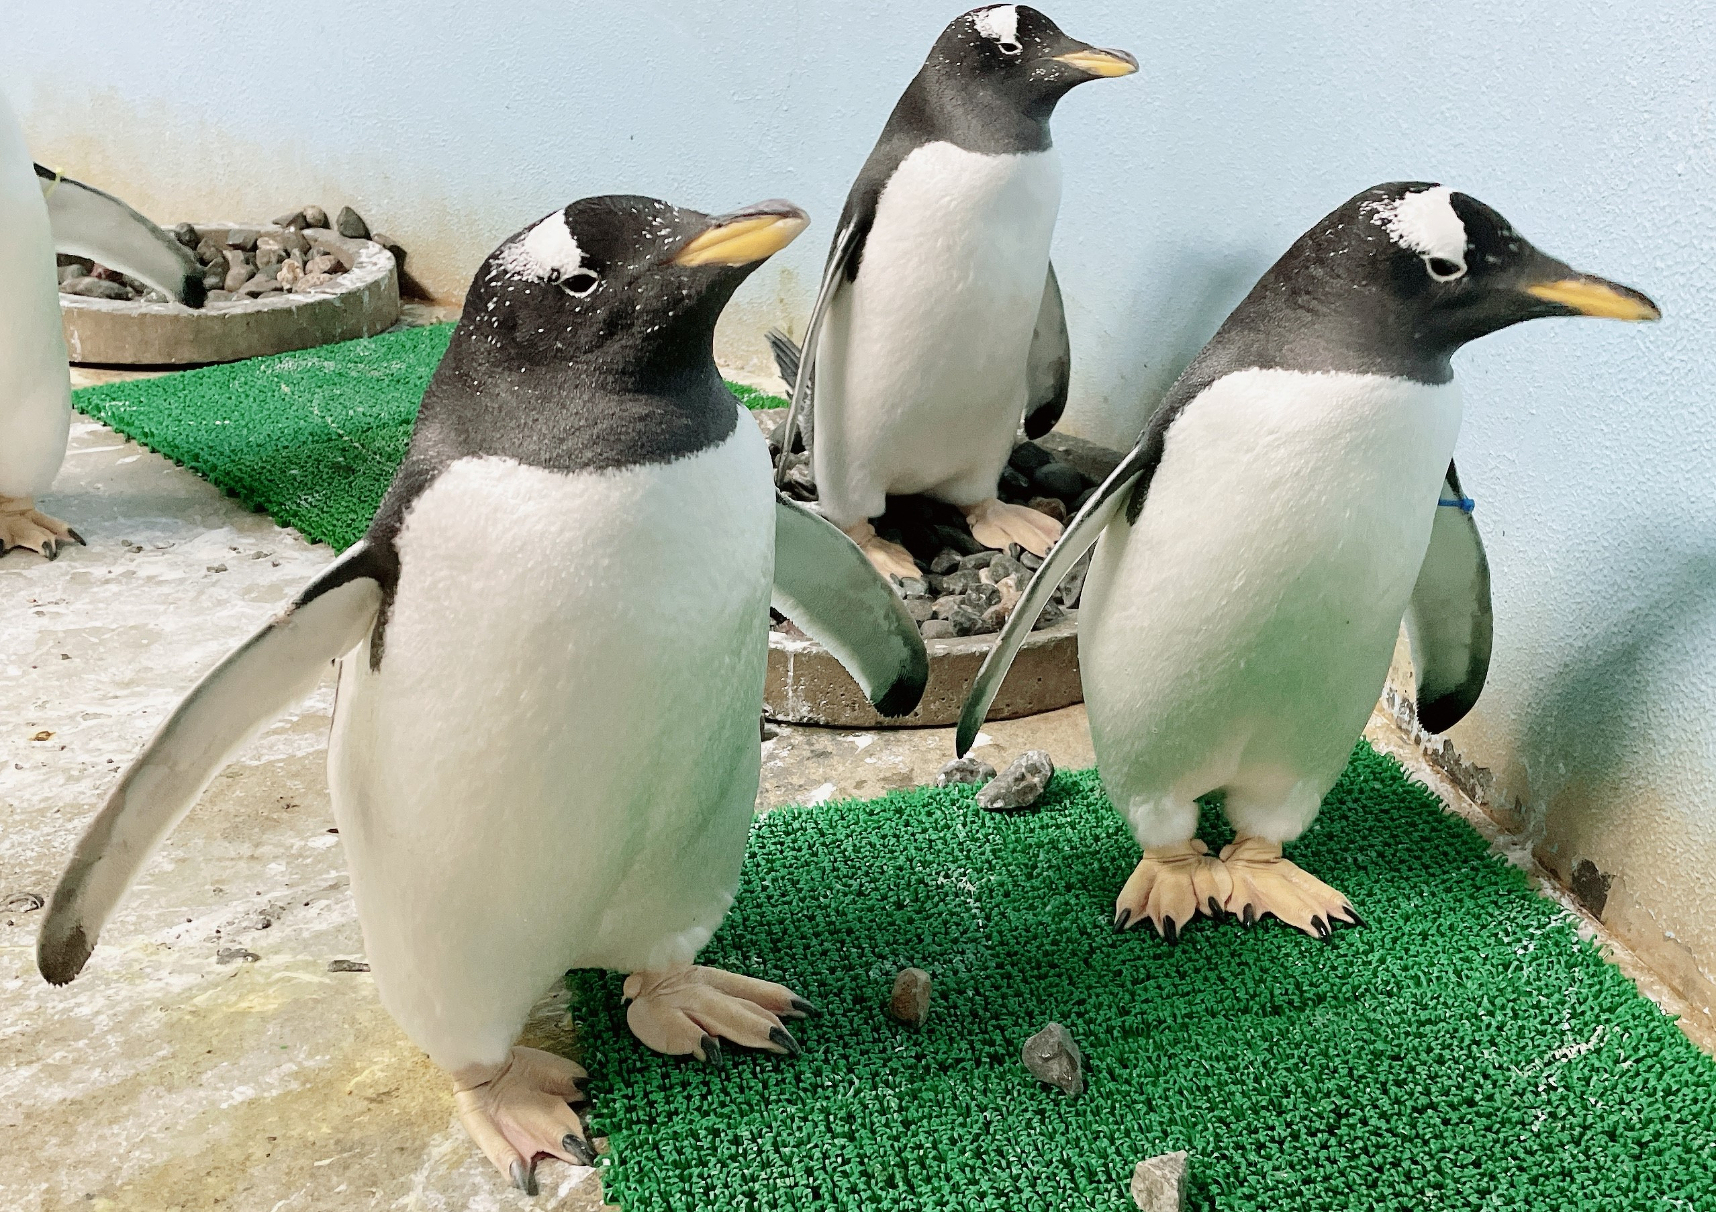

In [47]:
# prompt: http://images.cocodataset.org/val2017/000000439715.jpg をダウンロードしてImageに

from PIL import Image
import requests
from io import BytesIO

image_url = "https://noichizoo.or.jp/media/001/202303/1.jpg"
response = requests.get(image_url)
print(response.status_code)
image = Image.open(BytesIO(response.content))
image

# Now you can use the 'image' object for further processing.
# For example, you could display it:
# image.show()

In [48]:
print(image.size)

(1716, 1212)


In [49]:
input_image = image.convert("RGB")

入力画像の処理

In [50]:
from transformers import Mask2FormerImageProcessor

processor = Mask2FormerImageProcessor.from_pretrained(model_name)
inputs = processor(images=input_image, return_tensors="pt").to(device)

In [51]:
print(inputs)

{'pixel_values': tensor([[[[ 1.6324,  1.5982,  1.5982,  ...,  1.5468,  1.4783,  1.4783],
          [ 1.6153,  1.5982,  1.5810,  ...,  1.6495,  1.5639,  1.5468],
          [ 1.5982,  1.5639,  1.5810,  ...,  1.6153,  1.5639,  1.5297],
          ...,
          [ 1.5639,  1.7180,  1.6153,  ..., -1.5699, -1.8097, -1.7925],
          [ 1.7523,  1.7865,  1.8037,  ..., -1.8439, -1.7583, -1.1932],
          [ 1.8208,  1.7009,  1.8379,  ..., -1.7069, -1.6042, -1.1760]],

         [[ 1.9734,  1.9384,  1.9384,  ...,  1.9559,  1.8683,  1.8683],
          [ 1.9559,  1.9384,  1.9209,  ...,  2.0084,  1.9559,  1.9384],
          [ 1.9384,  1.9034,  1.9209,  ...,  1.9734,  1.9559,  1.9209],
          ...,
          [ 1.4832,  1.6758,  1.5532,  ...,  0.0476, -0.4426, -0.4076],
          [ 1.6933,  1.7633,  1.8158,  ..., -0.3901, -0.4426,  0.3277],
          [ 1.7808,  1.6758,  1.8508,  ..., -0.6702, -0.3200,  0.6254]],

         [[ 2.3437,  2.3088,  2.3263,  ...,  2.3088,  2.2391,  2.2391],
          [ 2

推論を実行する

In [52]:
print(inputs["pixel_values"].size())

torch.Size([1, 3, 384, 384])


In [53]:
model.to(device)
with torch.no_grad():
  outputs = model(**inputs)

推論結果を処理

In [54]:
results = processor.post_process_panoptic_segmentation(
    outputs, target_sizes=[image.size[::-1]]  # [高さ, 幅] の順
)[0]

`label_ids_to_fuse` unset. No instance will be fused.


In [55]:
results

{'segmentation': tensor([[7, 7, 7,  ..., 7, 7, 7],
         [7, 7, 7,  ..., 7, 7, 7],
         [7, 7, 7,  ..., 7, 7, 7],
         ...,
         [3, 3, 3,  ..., 6, 6, 6],
         [3, 3, 3,  ..., 6, 6, 6],
         [3, 3, 3,  ..., 6, 6, 6]], dtype=torch.int32),
 'segments_info': [{'id': 1,
   'label_id': 45,
   'was_fused': False,
   'score': 0.591853},
  {'id': 2, 'label_id': 14, 'was_fused': False, 'score': 0.999479},
  {'id': 3, 'label_id': 122, 'was_fused': False, 'score': 0.843165},
  {'id': 4, 'label_id': 14, 'was_fused': False, 'score': 0.999485},
  {'id': 5, 'label_id': 14, 'was_fused': False, 'score': 0.997456},
  {'id': 6, 'label_id': 132, 'was_fused': False, 'score': 0.995906},
  {'id': 7, 'label_id': 131, 'was_fused': False, 'score': 0.994889},
  {'id': 8, 'label_id': 14, 'was_fused': False, 'score': 0.963813}]}

In [56]:
results["segmentation"].size()

torch.Size([1212, 1716])

In [57]:
for key, value in results.items():
  print(f"{key}: {value}")

segmentation: tensor([[7, 7, 7,  ..., 7, 7, 7],
        [7, 7, 7,  ..., 7, 7, 7],
        [7, 7, 7,  ..., 7, 7, 7],
        ...,
        [3, 3, 3,  ..., 6, 6, 6],
        [3, 3, 3,  ..., 6, 6, 6],
        [3, 3, 3,  ..., 6, 6, 6]], dtype=torch.int32)
segments_info: [{'id': 1, 'label_id': 45, 'was_fused': False, 'score': 0.591853}, {'id': 2, 'label_id': 14, 'was_fused': False, 'score': 0.999479}, {'id': 3, 'label_id': 122, 'was_fused': False, 'score': 0.843165}, {'id': 4, 'label_id': 14, 'was_fused': False, 'score': 0.999485}, {'id': 5, 'label_id': 14, 'was_fused': False, 'score': 0.997456}, {'id': 6, 'label_id': 132, 'was_fused': False, 'score': 0.995906}, {'id': 7, 'label_id': 131, 'was_fused': False, 'score': 0.994889}, {'id': 8, 'label_id': 14, 'was_fused': False, 'score': 0.963813}]


セグメンテーション結果を取得

In [58]:
results['segmentation'].size()

torch.Size([1212, 1716])

In [59]:
predicted_panoptic_seg = results['segmentation'].cpu().numpy()
segments_info = results['segments_info']

セグメント情報を表示

In [60]:
for segment in segments_info:
    label = id2label[segment['label_id']]
    score = segment['score']
    print(f"Segment: {label}, Score: {score:.2f}")

Segment: bowl, Score: 0.59
Segment: bird, Score: 1.00
Segment: floor-other-merged, Score: 0.84
Segment: bird, Score: 1.00
Segment: bird, Score: 1.00
Segment: rug-merged, Score: 1.00
Segment: wall-other-merged, Score: 0.99
Segment: bird, Score: 0.96


セグメンテーションマスクの可視化

In [61]:
from PIL import Image
import numpy as np

def visualize_mask(segment, id2label):
    label = id2label[segment['label_id']]
    print(f"Visualizing mask for: {label}")

    # セグメントマスクを作成
    mask = (predicted_panoptic_seg == segment['id'])
    visual_mask = (mask * 255).astype(np.uint8)

    return visual_mask, label

可視化

In [62]:
import matplotlib.pyplot as plt

# Matplotlibで表示
def display_mask(mask, label):
    plt.figure(figsize=(6, 8))
    plt.title(f"Mask for: {label}")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")
    plt.show()

Visualizing mask for: bowl
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


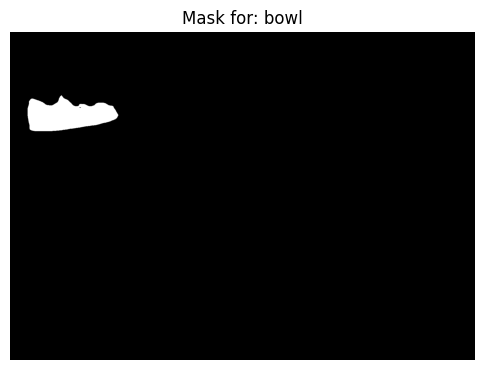

Visualizing mask for: bird
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


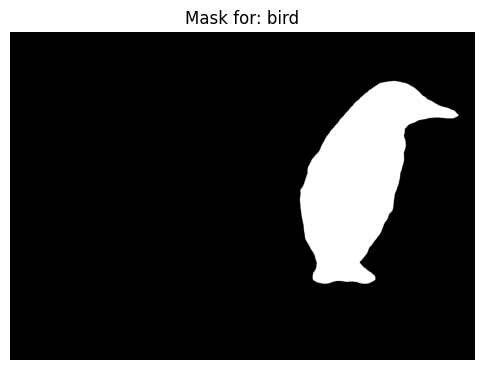

Visualizing mask for: floor-other-merged
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]]


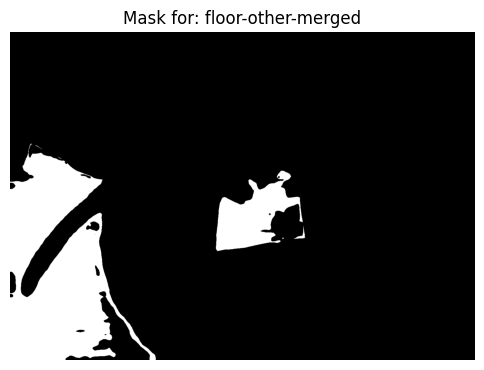

Visualizing mask for: bird
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


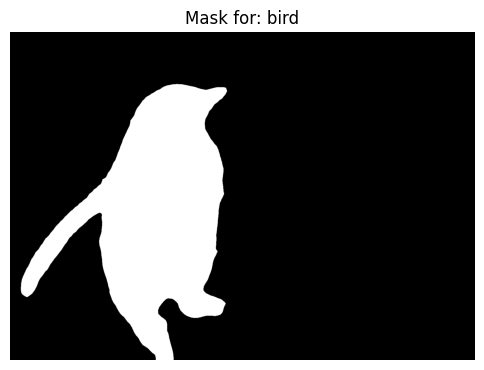

Visualizing mask for: bird
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


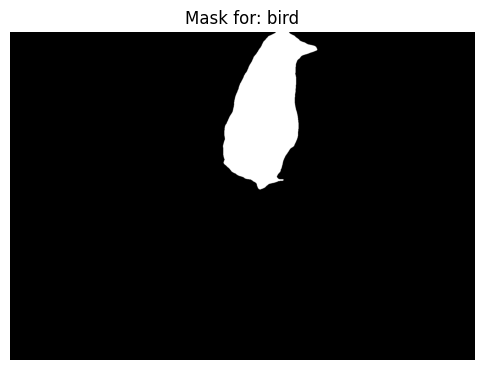

Visualizing mask for: rug-merged
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]]


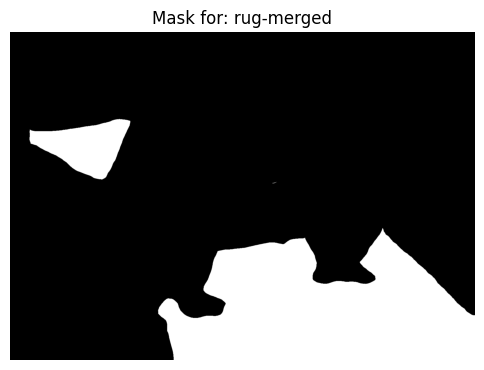

Visualizing mask for: wall-other-merged
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


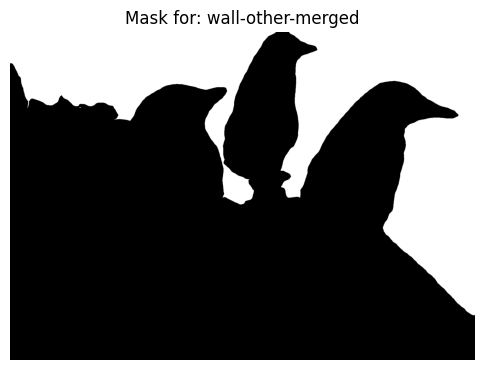

Visualizing mask for: bird
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


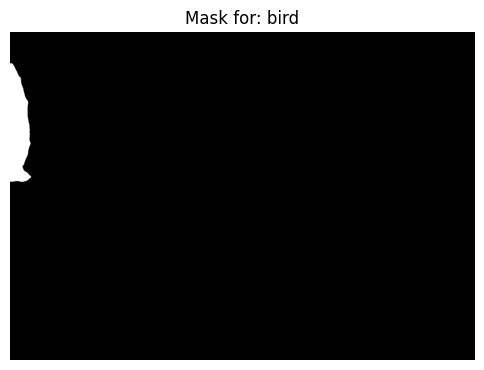

In [63]:
for segment in segments_info:
    mask, label = visualize_mask(segment, id2label)
    print(mask)
    display_mask(mask, label)

arg image_size: (1716, 1212)
Overlaying mask for: bowl
Overlaying mask for: bird
Overlaying mask for: floor-other-merged
Overlaying mask for: bird
Overlaying mask for: bird
Overlaying mask for: rug-merged
Overlaying mask for: wall-other-merged
Overlaying mask for: bird
Original Image Shape: (1212, 1716, 3)
Mask Overlay Shape: (1212, 1716, 3)
Predicted Panoptic Segmentation Shape: (1212, 1716)


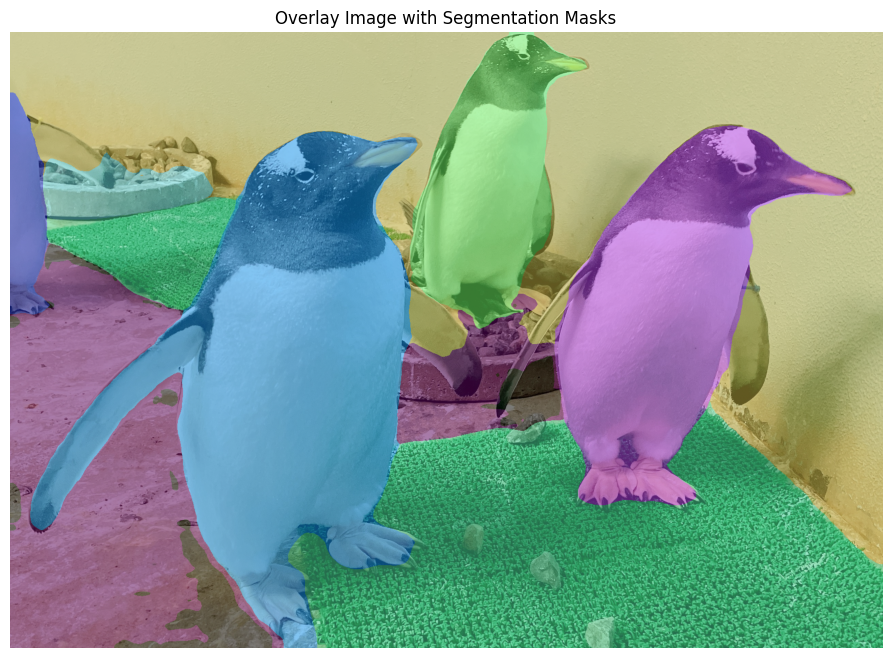

True

In [64]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def overlay_mask_on_image(image, predicted_panoptic_seg, segments_info, id2label):
    """
    元の画像にマスクを重ねて表示する。

    Args:
        image (PIL.Image.Image): 元の画像。
        predicted_panoptic_seg (np.ndarray): セグメンテーション結果の配列。
        segments_info (list): セグメント情報のリスト。
        id2label (dict): ラベルIDから名前へのマッピング。

    Returns:
        np.ndarray: 元の画像にマスクを重ねた画像。
    """
    # OpenCVで処理するため、PIL画像をNumPy配列に変換
    print("arg image_size:", image.size)
    original_image = np.array(image.convert("RGB"))

    # カラー画像の作成（マスク用）
    height, width = predicted_panoptic_seg.shape
    mask_overlay = np.zeros((height, width, 3), dtype=np.uint8)

    # セグメントごとにマスクを塗る
    np.random.seed(42)  # 再現性のためランダム色を固定
    for segment in segments_info:
        segment_id = segment["id"]
        label_id = segment["label_id"]
        label_name = id2label.get(label_id, "Unknown")
        print(f"Overlaying mask for: {label_name}")

        # ランダムな色を生成
        color = np.random.randint(0, 255, size=3, dtype=np.uint8)

        # セグメントのマスクを抽出
        mask = (predicted_panoptic_seg == segment_id)

        # マスクに色を適用
        mask_overlay[mask] = color

    # デバッグ情報の追加
    print(f"Original Image Shape: {original_image.shape}")          # (高さ, 幅, 3)
    print(f"Mask Overlay Shape: {mask_overlay.shape}")              # (高さ, 幅, 3)
    print(f"Predicted Panoptic Segmentation Shape: {predicted_panoptic_seg.shape}")  # (高さ, 幅)

    # マスクを透過させる
    alpha = 0.5  # 透過率
    try:
        overlay_image = cv2.addWeighted(mask_overlay, alpha, original_image, 1 - alpha, 0)
    except cv2.error as e:
        print(f"Error in addWeighted: {e}")
        return original_image  # エラー時は元の画像を返す

    return overlay_image


# マスクのオーバーレイ
overlay_image = overlay_mask_on_image(image, predicted_panoptic_seg, segments_info, id2label)

# Matplotlib で表示
plt.figure(figsize=(12, 8))
plt.title("Overlay Image with Segmentation Masks")
plt.imshow(overlay_image)
plt.axis("off")
plt.show()

# 必要に応じて保存
overlay_image_bgr = cv2.cvtColor(overlay_image, cv2.COLOR_RGB2BGR)
cv2.imwrite("overlay_result.jpg", overlay_image_bgr)